<a href="https://colab.research.google.com/github/jonathancagua/NLP/blob/main/EX/Desafio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [2]:
!pip install keras-preprocessing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [3]:
import logging
import os
import pickle
import re
from io import StringIO
from pathlib import Path

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import LSTM, Activation, Dense, Dropout, Flatten, Input, SimpleRNN
from keras.models import Model, Sequential
from keras_preprocessing.text import Tokenizer, one_hot
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import pad_sequences, plot_model, to_categorical

In [4]:
# Descargar la carpeta de dataset

import os  # Módulo para operaciones del sistema operativo
import gdown  # Módulo para descargar archivos desde Google Drive

# Verifica si el archivo 'data_volunteers.json' ya existe en el sistema
if os.access('data_volunteers.json', os.F_OK) is False:
    # URL directa al archivo en Google Drive (formato para descarga)
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'  # Nombre con el que se guardará el archivo localmente
    gdown.download(url, output, quiet=False)  # Descarga el archivo mostrando progreso
else:
    # Si el archivo ya existe, muestra un mensaje informando al usuario
    print("El dataset ya se encuentra descargado")


Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 14.1MB/s]


In [6]:
# dataset_file

import json

text_file = "data_volunteers.json"

# Abre el archivo JSON y carga su contenido como un diccionario de Python
with open(text_file) as f:
    data = json.load(f)  # la variable data será un diccionario


In [7]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [8]:
chat_in = []
chat_out = []

input_sentences = []           # Lista que almacenará las oraciones de entrada (encoder input)
output_sentences = []          # Lista que almacenará las oraciones de salida con token <eos> (decoder output)
output_sentences_inputs = []   # Lista que almacenará las oraciones de salida con token <sos> (decoder input)
max_len = 30                   # Longitud máxima permitida para una oración

def clean_text(txt):
    """
    Limpia y normaliza el texto:
    - Convierte a minúsculas
    - Reemplaza contracciones comunes
    - Elimina caracteres no alfanuméricos
    @param txt: texto en bruto
    @return: texto limpio
    """
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

# Recorremos cada conversación en el dataset
for line in data:
    for i in range(len(line['dialog'])-1):
        # Vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        # Se descartan pares de oraciones que excedan la longitud máxima
        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # La oración de salida (decoder_output) tendrá el token <eos>
        output_sentence = output + ' <eos>'
        # La entrada del decodificador (decoder_input) tendrá el token <sos>
        output_sentence_input = '<sos> ' + output

        # Se almacenan en las listas correspondientes
        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

# Se imprime la cantidad de pares de oraciones válidos utilizados
print("Cantidad de rows utilizadas:", len(input_sentences))


Cantidad de rows utilizadas: 6033


In [9]:
print(input_sentences[1])
print(output_sentences[1])
print(output_sentences_inputs[1])


hi how are you 
not bad and you  <eos>
<sos> not bad and you 


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [10]:
MAX_VOCAB_SIZE = 8000  # Tamaño máximo del vocabulario que se considerará

# Se crea el tokenizador limitando el número máximo de palabras
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

# Se ajusta el tokenizador al texto: se añaden explícitamente los tokens <sos> y <eos>,
# además de todas las oraciones de entrada y salida
tokenizer.fit_on_texts(["<sos>", "<eos>"] + input_sentences + output_sentences)

# Se convierte cada oración en una secuencia de enteros usando el vocabulario aprendido
input_seq = tokenizer.texts_to_sequences(input_sentences)            # Secuencias de entrada (encoder)
output_seq = tokenizer.texts_to_sequences(output_sentences)          # Secuencias objetivo del decodificador (con <eos>)
output_input_seq = tokenizer.texts_to_sequences(output_sentences_inputs)  # Secuencias de entrada del decodificador (con <sos>)

# Diccionario que mapea palabras a sus respectivos índices en el vocabulario
voc_indexes = tokenizer.word_index

# Información general sobre el vocabulario y longitudes máximas
print("Tamaño del vocabulario:", len(voc_indexes))  # Cantidad de palabras distintas
print("Max input:", max(len(sen) for sen in input_seq))  # Máxima longitud de una secuencia de entrada
print("Max output:", max(len(sen) for sen in output_seq))  # Máxima longitud de una secuencia de salida


Tamaño del vocabulario: 2157
Max input: 9
Max output: 10


In [11]:
MAX_IN = 16   # Longitud máxima para las secuencias de entrada al encoder
MAX_OUT = 16  # Longitud máxima para las secuencias de entrada al decoder

# Se rellenan las secuencias de entrada al encoder con ceros al principio (padding por defecto: 'pre')
encoder_input = pad_sequences(input_seq, maxlen=MAX_IN)

# Se rellenan las secuencias de entrada al decoder con ceros al final (padding='post')
encoder_output = pad_sequences(output_input_seq, maxlen=MAX_OUT, padding='post')


In [12]:
# Se define el número total de palabras a considerar en la salida:
# - Se suma 1 para incluir el token cero (usado en padding)
# - Se limita al tamaño máximo definido
num_words_output = min(len(voc_indexes) + 1, MAX_VOCAB_SIZE)

# Se rellena la secuencia de salida del decodificador con ceros al final (tiene <eos>)
decoder_output = pad_sequences(output_seq, maxlen=MAX_OUT, padding='post')

# Se convierte cada palabra en una codificación one-hot para entrenamiento supervisado
# La salida será un array tridimensional: (n_samples, MAX_OUT, num_words_output)
decoder_targets = to_categorical(decoder_output, num_classes=num_words_output)

# Se muestra la forma del tensor resultante
decoder_targets.shape


(6033, 16, 2158)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [13]:
# Verifica si el archivo 'gloveembedding.pkl' ya está descargado en el sistema
if os.access('gloveembedding.pkl', os.F_OK) is False:
    # URL directa para descargar el archivo desde Google Drive
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'  # Nombre local para guardar el archivo
    gdown.download(url, output, quiet=False)  # Descarga el archivo mostrando progreso
else:
    # Mensaje informativo si el archivo ya existe localmente
    print("Los embeddings gloveembedding.pkl ya están descargados")


Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=1c6606de-2ed5-415f-9e8f-52da0107b34a
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:04<00:00, 117MB/s]


In [14]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # Carga los embeddings: si el archivo pickle existe, lo carga,
        # si no, convierte el archivo de texto en pickle y lo carga.
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings

        # Construye los diccionarios de vocabulario para convertir
        # palabra -> índice y índice -> palabra
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        # Obtiene los embeddings correspondientes a una lista de palabras
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        # Convierte una lista de palabras a sus índices en el vocabulario,
        # si la palabra no existe devuelve -1
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        # Convierte una lista de índices a palabras,
        # si el índice no existe devuelve '-1'
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        # Carga el archivo pickle de embeddings desde disco
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1  # Tamaño máximo a leer en cada fragmento (256MB)
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)

        # Lee el archivo en fragmentos para evitar problemas con archivos grandes
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)

        embeddings = pickle.loads(bytes_in)  # Deserializa el objeto
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # Convierte el archivo de texto de embeddings a un formato pickle para carga rápida posterior
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        # Definición de la estructura del numpy array con palabra y vector embedding
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)

        # Lee el archivo de texto generando un iterable de (palabra, vector embedding)
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)

        # Añade un embedding nulo para palabras desconocidas o padding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])

        # Guarda el array numpy en disco en formato pickle en fragmentos para evitar errores
        max_bytes = 2**28 - 1  # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])

        self.logger.debug('words embeddings loaded')
        return embeddings


# Clases concretas que heredan de WordsEmbeddings con sus configuraciones específicas
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'  # Archivo txt de embeddings GloVe
    PKL_PATH = 'gloveembedding.pkl'                          # Archivo pickle donde se guarda la conversión
    N_FEATURES = 50                                          # Dimensión de los vectores de embedding
    WORD_MAX_SIZE = 60                                       # Tamaño máximo de una palabra en caracteres


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'  # Archivo txt de embeddings FastText
    PKL_PATH = 'fasttext.pkl'                      # Archivo pickle donde se guarda la conversión
    N_FEATURES = 300                               # Dimensión de los vectores de embedding
    WORD_MAX_SIZE = 60                             # Tamaño máximo de una palabra en caracteres


In [15]:
model_embeddings = GloveEmbeddings()
# Crea una instancia de la clase GloveEmbeddings, la cual:
# - Carga los vectores de palabras preentrenados GloVe (50 dimensiones).
# - Si el archivo pickle con los embeddings no existe, lo genera a partir del archivo de texto.
# - Construye diccionarios para convertir palabras a índices y viceversa.
# Esta instancia puede usarse para obtener los vectores embedding de palabras en tu vocabulario.


In [16]:
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES  # Dimensión de cada vector embedding (50 para GloVe)
words_not_found = []  # Lista para almacenar palabras no encontradas en los embeddings preentrenados

# word_index provienen del tokenizer, que asigna un índice a cada palabra

nb_words = min(MAX_VOCAB_SIZE, len(voc_indexes))  # Número de palabras a considerar (máximo vocab size)
embedding_matrix = np.zeros((nb_words, embed_dim))  # Matriz que contendrá los vectores embedding para cada palabra

for word, i in voc_indexes.items():
    if i >= nb_words:
        continue  # Ignora índices fuera del rango máximo permitido
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]  # Obtiene el embedding para la palabra
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector  # Asigna el vector embedding en la matriz
    else:
        # Si la palabra no está en los embeddings preentrenados, se añade a la lista words_not_found
        words_not_found.append(word)

# Muestra cuántos vectores embedding son nulos (todos ceros), es decir, palabras no encontradas
print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))


preparing embedding matrix...
number of null word embeddings: 44


In [17]:
embedding_matrix.shape

(2157, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [18]:
n_units = 128  # Número de unidades (neuronas) en las capas LSTM

# Definición del encoder para entrenamiento
encoder_inputs = Input(shape=(MAX_IN,))  # Entrada para el encoder, secuencia de longitud MAX_IN

# Capa de embedding para el encoder:
# Usa la matriz de embeddings preentrenados (glove) y no se entrena durante el aprendizaje
encoder_embedding_layer = Embedding(
          input_dim=nb_words,      # Número de palabras en vocabulario
          output_dim=embed_dim,    # Dimensión del vector embedding (50 en este caso)
          input_length=MAX_IN,     # Longitud máxima de secuencia de entrada
          weights=[embedding_matrix],  # Matriz con vectores preentrenados
          trainable=False)         # No actualizar embeddings durante entrenamiento

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)  # Aplicar capa embedding a la entrada

# Capa LSTM para el encoder que devuelve el estado final (oculto y de celda)
encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]  # Estados que se pasan al decoder

# Definición del decoder para entrenamiento
decoder_inputs = Input(shape=(MAX_OUT,))  # Entrada para el decoder, secuencia de longitud MAX_OUT

# Capa de embedding para el decoder, sin pesos preentrenados, salida con dimensión igual a n_units
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=MAX_OUT)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)  # Aplicar capa embedding a entrada del decoder

# Capa LSTM para el decoder que devuelve secuencia completa y estados, inicializado con estados del encoder
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Capa densa para convertir las salidas LSTM a distribuciones de probabilidad sobre el vocabulario (softmax)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo completo que toma entrada encoder y decoder y devuelve las predicciones para cada paso de tiempo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilación del modelo con función de pérdida categorical_crossentropy y optimizador Adam
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

# Mostrar resumen de la arquitectura del modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 16, 50)    │    107,850 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 16, 128)   │    276,224 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     91,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 16, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16, 2158)  │    278,382 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 885,688 (3.38 MB)

 Trainable params: 777,838 (2.97 MB)

 Non-trainable params: 107,850 (421.29 KB)

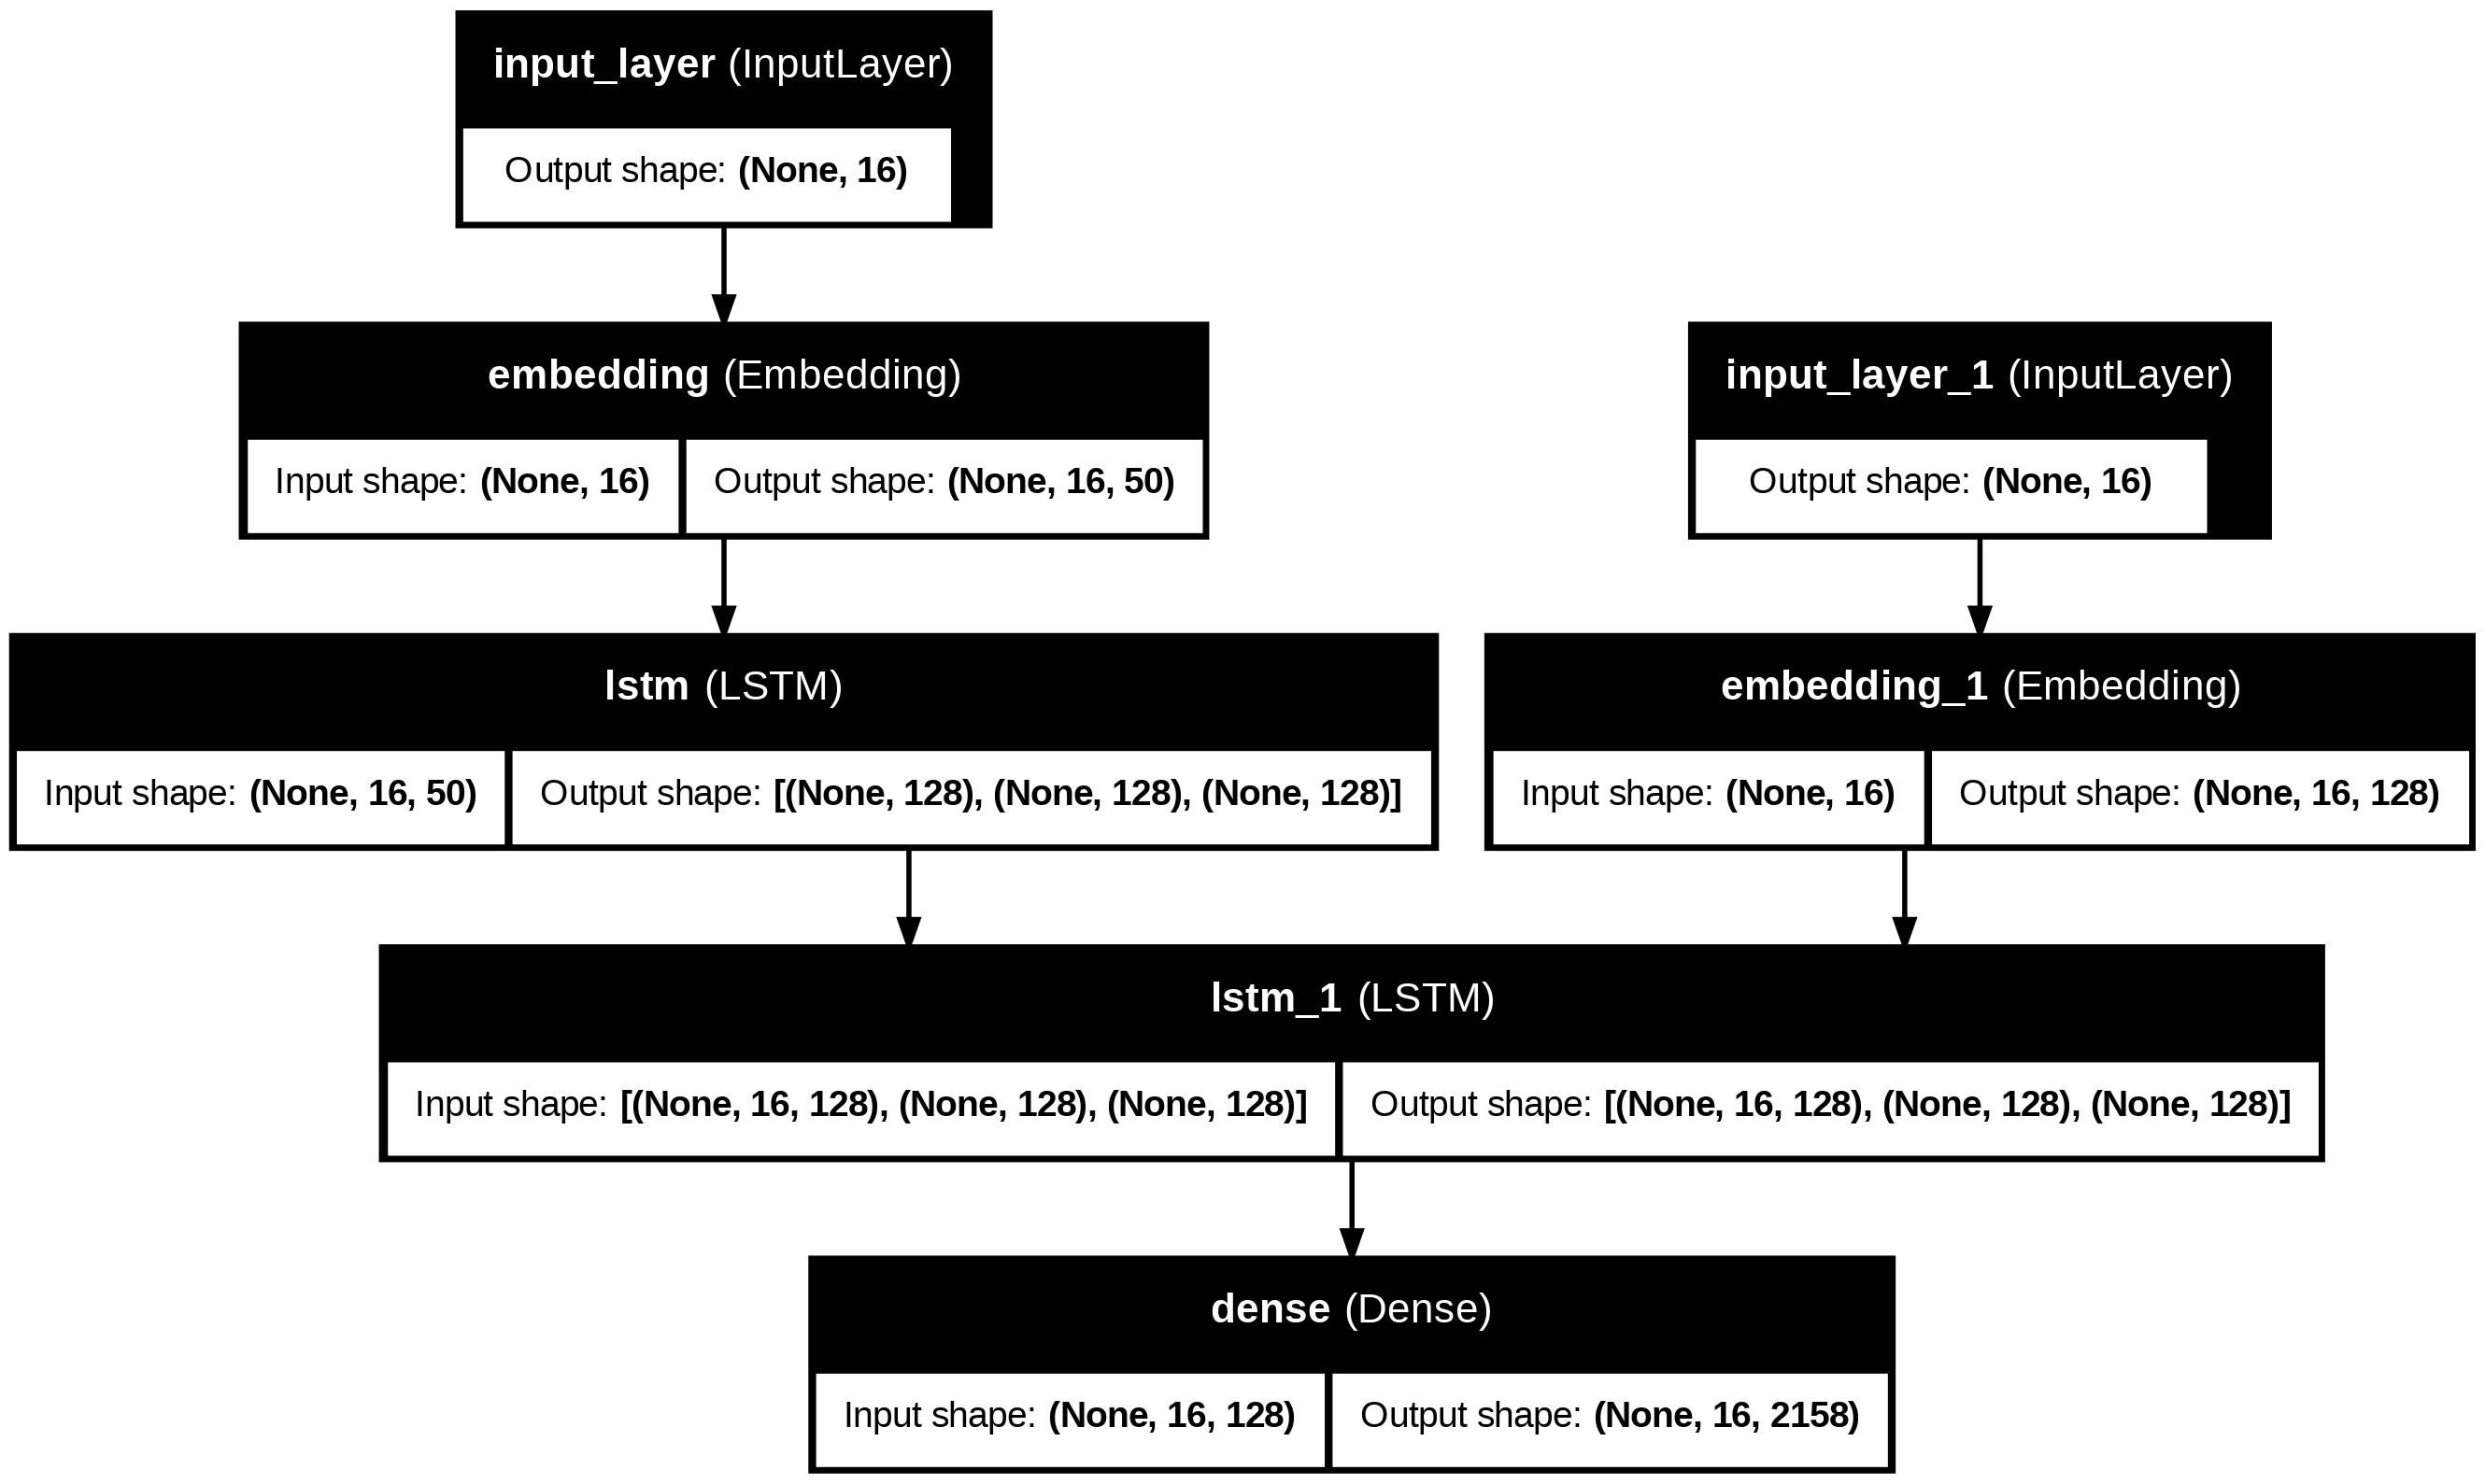

In [19]:
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

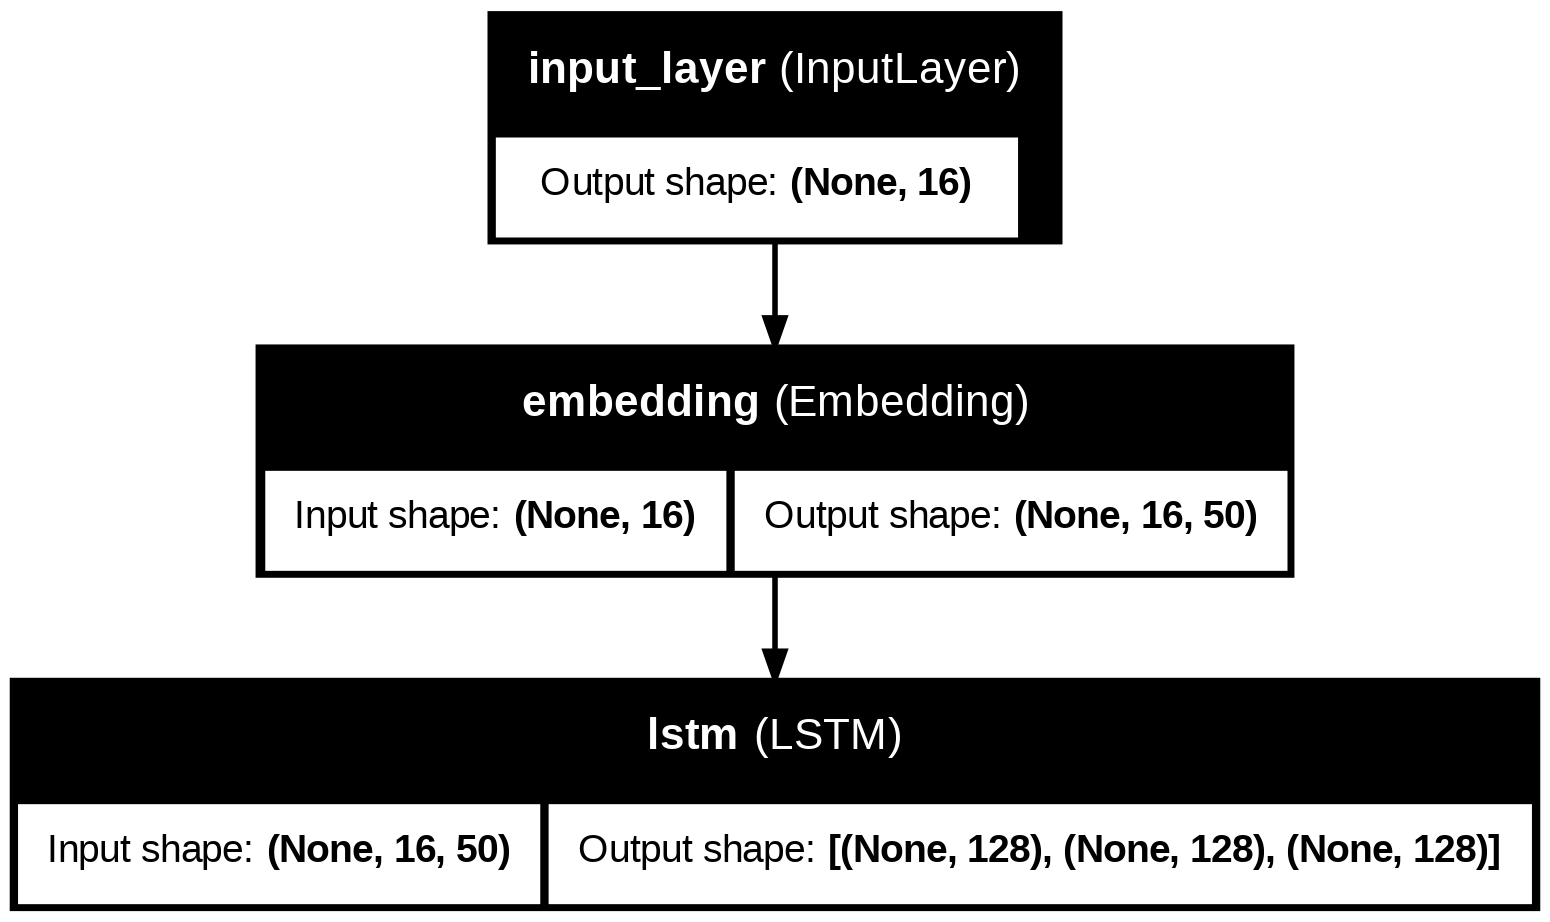

In [20]:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

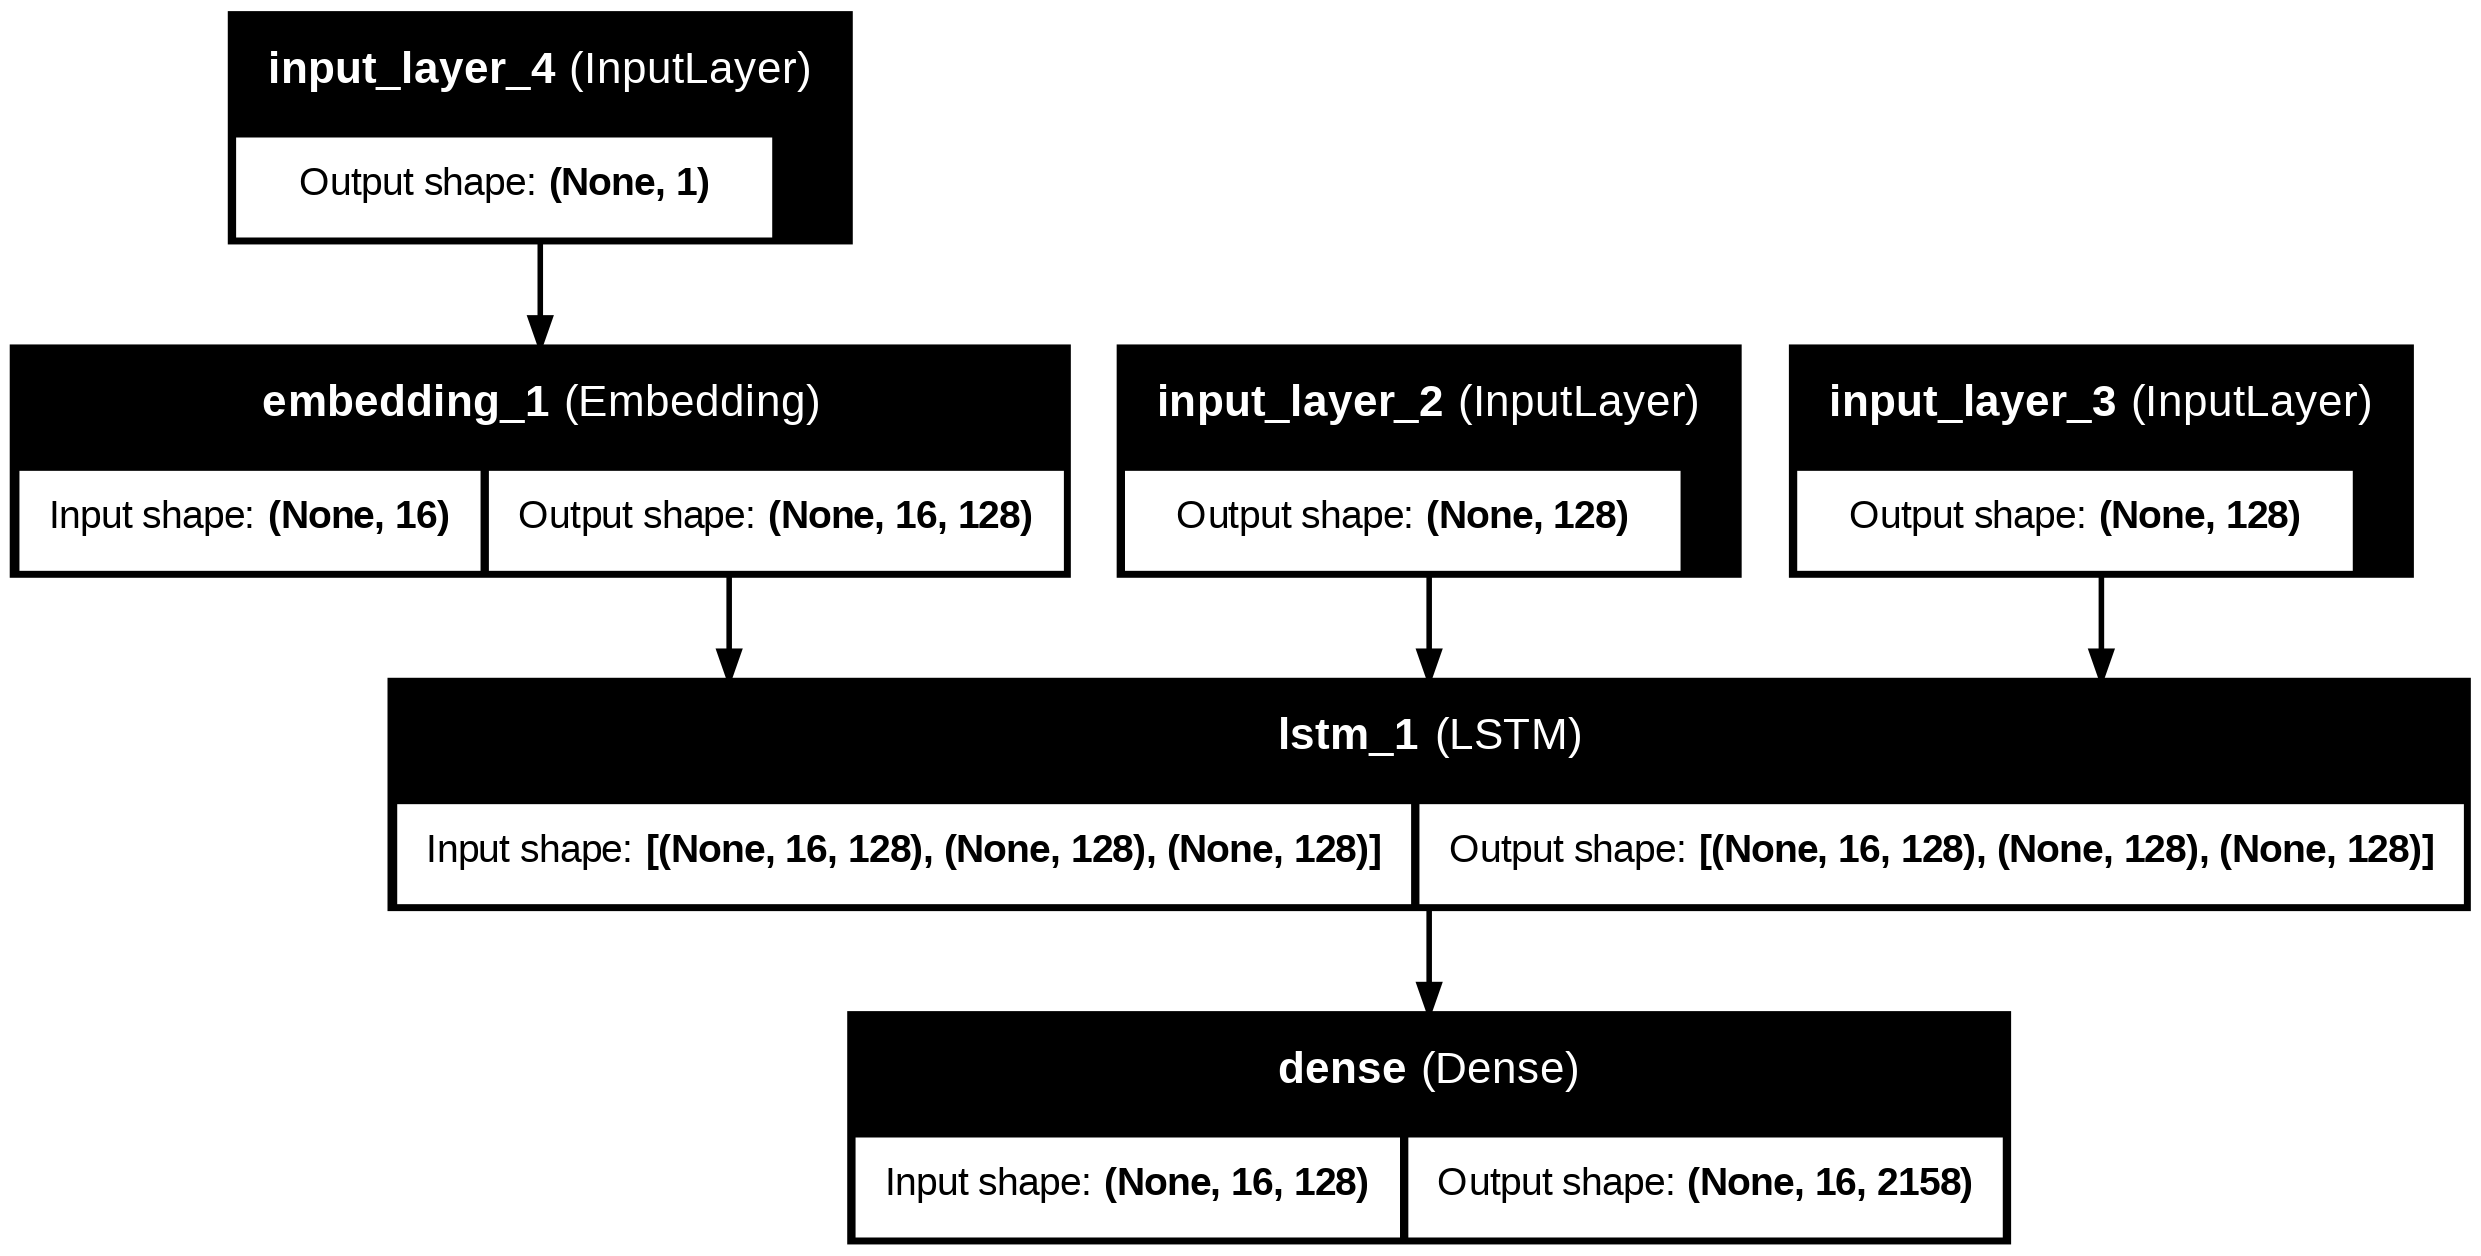

In [21]:
# Inputs para los estados ocultos y de celda del decoder en la inferencia
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En la inferencia (generación de texto), el decoder procesa una palabra a la vez,
# por eso la entrada del decoder ahora es secuencia de longitud 1 (una palabra)
decoder_inputs_single = Input(shape=(1,))
# Aplicar la capa embedding al input de una sola palabra
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# Pasar el embedding y los estados previos al LSTM del decoder
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
# Guardar los estados actualizados para alimentar la siguiente predicción
decoder_states = [state_h, state_c]

# Pasar la salida del LSTM por la capa densa para obtener la distribución sobre el vocabulario
decoder_outputs = decoder_dense(decoder_outputs)

# Definir el modelo del decoder para la inferencia:
# toma como entrada la palabra actual y los estados previos,
# y devuelve la predicción de la siguiente palabra y los nuevos estados
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Visualizar el modelo decoder y guardar la imagen en 'decoder_plot.png'
plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
hist = model.fit(
    [encoder_input, encoder_output],  # Entradas del modelo: secuencias codificadas para encoder y decoder
    decoder_targets,                  # Salidas esperadas (one-hot) para el decoder
    epochs=150,                      # Número de épocas para entrenar el modelo
    validation_split=0.2             # Porcentaje (20%) de los datos usados para validación durante el entrenamiento
)


Epoch 1/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 32s 173ms/step - accuracy: 0.6700 - loss: 3.5933 - val_accuracy: 0.7702 - val_loss: 1.4016
Epoch 2/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.7604 - loss: 1.3223 - val_accuracy: 0.7798 - val_loss: 1.3123
Epoch 3/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 151ms/step - accuracy: 0.7825 - loss: 1.2050 - val_accuracy: 0.8003 - val_loss: 1.2291
Epoch 4/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.8082 - loss: 1.0877 - val_accuracy: 0.8074 - val_loss: 1.1746
Epoch 5/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.8179 - loss: 1.0131 - val_accuracy: 0.8121 - val_loss: 1.1374
Epoch 6/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.8280 - loss: 0.9523 - val_accuracy: 0.8180 - val_loss: 1.1082
Epoch 7/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - accuracy: 0.8324 - loss: 0.9300 - val_accuracy: 0.8205 - val_loss: 1.0897
Epoch 8/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.8363 -

In [ ]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)  # Crea un rango con los números de época desde 1 hasta la última época entrenada

sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='train')       # Grafica la precisión del entrenamiento por época
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='valid')   # Grafica la precisión de validación por época

plt.show()


### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [ ]:

idx2word = {v: k for k, v in voc_indexes.items()}


In [ ]:
def process_sentence(input_seq):
    # Se transforma la secuencia de entrada a los estados "h" y "c" de la LSTM
    # para enviarlos la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder con "<sos>" (start of sentence)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = voc_indexes['sos']

    # Se obtiene el índice correspondiente al token que indica el final de la oración ("<eos>")
    eos = voc_indexes['eos']

    output_sentence = []
    for _ in range(MAX_OUT):
        # Se predice el siguiente token con el decoder, usando la entrada actual y los estados previos
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])  # Se obtiene el índice del token con mayor probabilidad

        # Si el token predicho es el de fin de frase "<eos>", se termina la generación
        if eos == idx:
            break

        # Si el índice es válido (>0), se convierte a palabra y se agrega a la lista resultado
        word = ''
        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)

        # Se actualizan los estados "h" y "c" con los nuevos valores para la siguiente iteración
        states_value = [h, c]

        # Se actualiza la secuencia de entrada del decoder con la última palabra predicha (realimentación)
        target_seq[0, 0] = idx

    # Se unen las palabras generadas en una cadena y se retorna como la oración final
    return ' '.join(output_sentence)


In [ ]:
# Selecciona un índice aleatorio dentro del rango de las oraciones de entrada.
i = np.random.choice(len(input_sentences))

# Extrae la secuencia de entrada correspondiente a ese índice.
# Se usa slicing [i:i+1] para mantener la dimensión 2D requerida por el modelo.
input_seq = encoder_input[i:i+1]

# Genera una respuesta utilizando el modelo de secuencia a secuencia entrenado.
answer = process_sentence(input_seq)

# Imprime un separador para claridad visual.
print('-')

# Muestra la oración original (entrada del encoder).
print('Input:', input_sentences[i])

# Muestra la respuesta generada por el modelo (salida del decoder).
print('Response:', answer)


In [ ]:
def test_input_sentence(input_text):
    print('Input:', input_text)
    integer_seq = tokenizer.texts_to_sequences([input_text])[0]
    print("Representación en vector de tokens de IDs:", integer_seq)
    encoder_sequence = pad_sequences([integer_seq], maxlen=MAX_IN)
    print("Padding del vector:", encoder_sequence)
    answer = process_sentence(encoder_sequence)
    print('Response:', answer)
    print('-' * 50)  # Separador visual

# Lista de oraciones a probar
test_sentences = [
    "Is she pretty?",
    "And what is your hobby?",
    "And what about Iggy Pop?",
    "Are you and your wife millennial too?",
    "What do you do for fun?",
    "And do you hate Chinese people?"
]

# Ejecutar pruebas
for sentence in test_sentences:
    test_input_sentence(sentence)
